##Setup

In [33]:
from torchvision import transforms
import numpy as np
import pandas as pd
import tensorflow as tf

In [34]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
from matplotlib import pyplot as plt
from PIL import Image
import requests


In [35]:
# Utility functions for image loading, preprocessing, and plotting

def load_and_preprocess_image(path, target_size=(256, 256)):
    """Load an image and resize/scale it for the model."""
    img = Image.open(path).convert('RGB')
    img = img.resize(target_size)
    img = np.array(img) / 255.0
    return img


def plot_images(images, labels=None, ncols=4, figsize=(20, 5)):
    fig, ax = plt.subplots(ncols=ncols, figsize=figsize)
    for idx, img in enumerate(images[:ncols]):
        ax[idx].imshow(img.astype(np.float32))
        if labels is not None:
            ax[idx].set_title(str(labels[idx]))
        ax[idx].axis('off')
    plt.show()


In [36]:
import pyarrow as pa
import pyarrow.parquet as pq
%pip install datasets

Note: you may need to restart the kernel to use updated packages.


##Loading the Dataset

In [37]:
from datasets import load_dataset
import shutil

#dataset = load_dataset("vikhyatk/synthetic-pepe")

In [38]:
#print(dataset)

In [39]:
pepecheck = tf.keras.utils.image_dataset_from_directory('pepecheck')

Found 509 files belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.6328125..254.03125].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [73.19903..213.77103].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


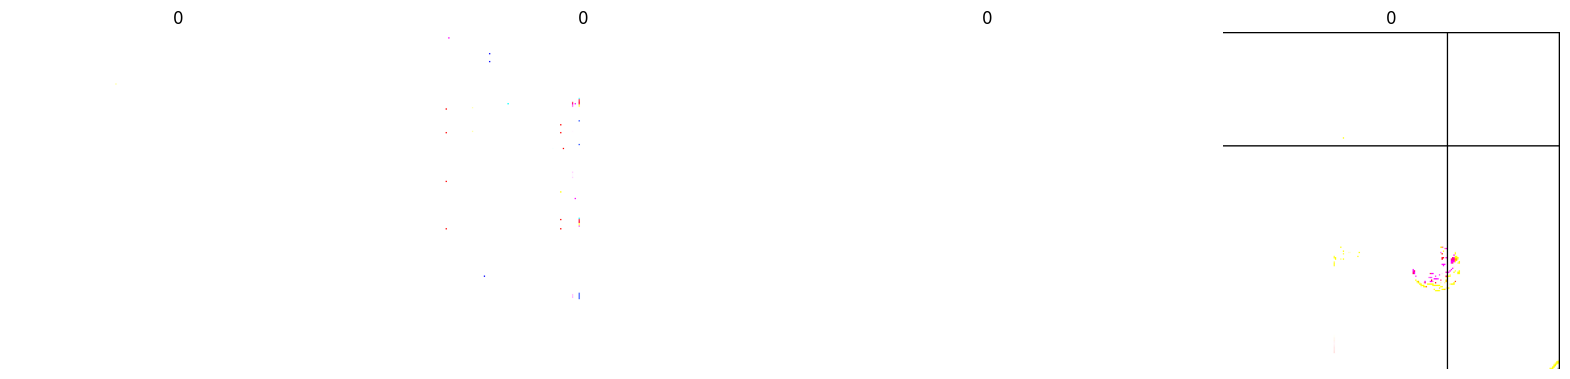

In [40]:
# Use utility function for plotting
data_iterator = pepecheck.as_numpy_iterator()
batch = data_iterator.next()
plot_images(batch[0], batch[1])

##Scaling the data

In [41]:
# Data scaling function
pepecheck = pepecheck.map(lambda x, y: (x / 255.0, y))
pepecheck.as_numpy_iterator().next()

(array([[[[0.03921569, 0.00392157, 0.09411765],
          [0.03921569, 0.00392157, 0.09411765],
          [0.03921569, 0.00392157, 0.09411765],
          ...,
          [0.0425301 , 0.00534827, 0.10135363],
          [0.04193657, 0.00427207, 0.10076009],
          [0.04214349, 0.00464726, 0.0998411 ]],
 
         [[0.03921569, 0.00392157, 0.09411765],
          [0.03921569, 0.00392157, 0.09411765],
          [0.03921569, 0.00392157, 0.09411765],
          ...,
          [0.04302383, 0.00598812, 0.10184736],
          [0.04291295, 0.00442927, 0.10173648],
          [0.04295161, 0.00497272, 0.10064922]],
 
         [[0.03921569, 0.00392157, 0.09411765],
          [0.03921569, 0.00392157, 0.09411765],
          [0.03921569, 0.00392157, 0.09411765],
          ...,
          [0.04275695, 0.00564225, 0.10158048],
          [0.04226409, 0.0043443 , 0.10108762],
          [0.04226409, 0.00479679, 0.1002124 ]],
 
         ...,
 
         [[0.03921569, 0.00392157, 0.09411765],
          [0.03921

##Splitting into training, testing and validation sets


In [42]:
train_size = int(len(pepecheck)*.7)
val_size = int(len(pepecheck)*.15)
test_size = int(len(pepecheck)*.15)

train_size



11

In [43]:
train = pepecheck.take(train_size)
val = pepecheck.skip(train_size).take(val_size)
test = pepecheck.skip(train_size+val_size).take(test_size)

##Model building

In [44]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [45]:
model = Sequential()

In [46]:
# Model building as a function for reusability
def build_model(input_shape=(256, 256, 3)):
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = build_model()

In [47]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

##Training the model

In [49]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

logdir = 'logs'
checkpoint_path = 'best_model.keras'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss')

hist = model.fit(
    train,
    epochs=20,
    validation_data=val,
    callbacks=[tensorboard_callback, early_stop, model_checkpoint]
)


Epoch 1/20


11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 563ms/step - accuracy: 0.9943 - loss: 0.0598 - val_accuracy: 1.0000 - val_loss: 1.2986e-22
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 518ms/step - accuracy: 1.0000 - loss: 9.4927e-19 - val_accuracy: 1.0000 - val_loss: 3.4724e-34
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 444ms/step - accuracy: 1.0000 - loss: 2.3722e-23 - val_accuracy: 1.0000 - val_loss: 7.8077e-36
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 1.0000 - loss: 2.0344e-26 - val_accuracy: 1.0000 - val_loss: 6.1997e-38
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 539ms/step - accuracy: 1.0000 - loss: 5.3065e-27 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 480ms/step - accuracy: 1.0000 - loss: 3.0963e-27 - val_accuracy: 1.0000 - val_loss: 5.2900e-38
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 404ms/step - accuracy: 1.0000 - loss: 2.4816e-27 - val_accuracy: 1.0000 - val_loss: 7.5200e-27
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 443ms/step - accuracy:

##Performance plots

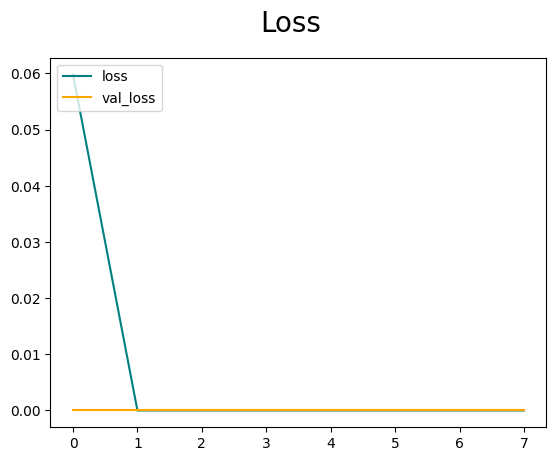

In [50]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

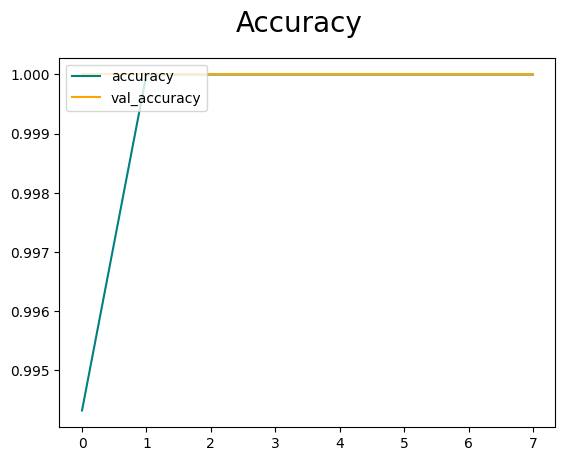

In [51]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

##Evaluation

In [52]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

# Evaluate on test set
def evaluate_model(model, test):
    for batch in test.as_numpy_iterator():
        X, y = batch
        ycap = model.predict(X)
        pre.update_state(y, ycap)
        re.update_state(y, ycap)
        acc.update_state(y, ycap)
    print('Precision:', pre.result().numpy(), 'Recall:', re.result().numpy(), 'Accuracy:', acc.result().numpy())

evaluate_model(model, test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Precision: 0.0 Recall: 0.0 Accuracy: 1.0


##Testing

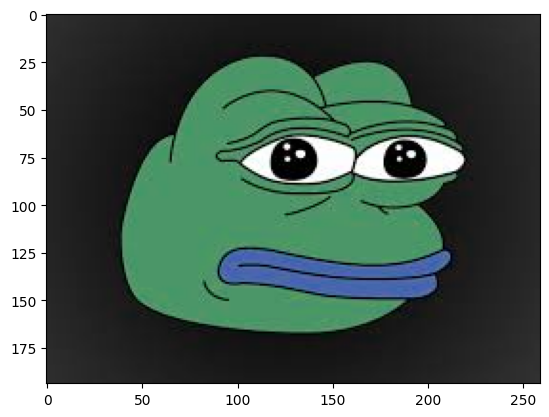

In [53]:
import cv2

img = cv2.imread('pepelol.jpeg')
plt.imshow(img) #cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.show()



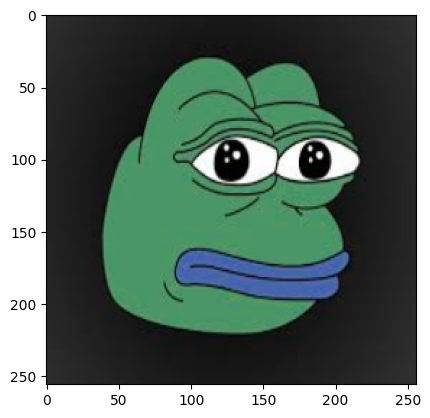

In [54]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [55]:
ycap = model.predict(np.expand_dims(resize/255, 0))

ycap



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


array([[0.]], dtype=float32)

In [56]:
if ycap > 0.5:
    print(f'No pepe found :(')
else:
    print(f'Pepe found :)')

Pepe found :)
